In [1]:
# @title Libraries
!pip -q install timm==0.9.16

import os, glob, random, time, warnings
from pathlib import Path
import numpy as np
import pandas as pd

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms
import torchvision.transforms.functional as TF

from sklearn.metrics import roc_auc_score
from tqdm.auto import tqdm
from datetime import datetime
from zoneinfo import ZoneInfo
from contextlib import nullcontext

import timm
from timm.utils import ModelEmaV2
warnings.filterwarnings("ignore")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 24.6 MB/s eta 0:00:00


In [2]:
# Cargar el Dataset de Abandono de Clientes de Telco
url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"
df = pd.read_csv(url)

print("="*60)
print("ABANDONO DE CLIENTES TELCO - ENTRENAMIENTO RED NEURONAL")
print("="*60)
print(f"\nForma del Dataset: {df.shape}")
print(f"\nPrimeras filas:")
print(df.head())
print(f"\nDistribución de Abandono:")
print(df['Churn'].value_counts())
print(f"\nInformación del Dataset:")
print(df.info())

ABANDONO DE CLIENTES TELCO - ENTRENAMIENTO RED NEURONAL

Forma del Dataset: (7043, 21)

Primeras filas:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# --- 1. Data Preprocessing ---

# Create a copy to avoid modifying the original DataFrame directly
df_processed = df.copy()

# Convert 'TotalCharges' to numeric, coercing errors to NaN
df_processed['TotalCharges'] = pd.to_numeric(df_processed['TotalCharges'], errors='coerce')

# Fill missing 'TotalCharges' with 0 (or median/mean, depending on data characteristics)
df_processed['TotalCharges'].fillna(0, inplace=True)

# Drop 'customerID' as it's not a predictive feature
df_processed.drop('customerID', axis=1, inplace=True)

# Encode target variable 'Churn': 'Yes' -> 1, 'No' -> 0
le = LabelEncoder()
df_processed['Churn'] = le.fit_transform(df_processed['Churn'])

# Identify categorical and numerical features
categorical_features = df_processed.select_dtypes(include='object').columns

# One-hot encode categorical features
df_processed = pd.get_dummies(df_processed, columns=categorical_features, drop_first=True)

# Separate features (X) and target (y)
X = df_processed.drop('Churn', axis=1)
y = df_processed['Churn']

# --- 2. Split Data ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nShape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

# --- 3. Train Random Forest Model ---
print("\nEntrenando modelo Random Forest...")
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced') # class_weight for imbalanced data
model.fit(X_train, y_train)
print("Modelo Random Forest entrenado exitosamente.")

# --- 4. Evaluate Model ---
y_pred = model.predict(X_test)

print("\n--- Evaluación del Modelo Random Forest ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Shape of X_train: (5634, 30)
Shape of X_test: (1409, 30)
Shape of y_train: (5634,)
Shape of y_test: (1409,)

Entrenando modelo Random Forest...
Modelo Random Forest entrenado exitosamente.

--- Evaluación del Modelo Random Forest ---
Accuracy: 0.7913

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1035
           1       0.64      0.49      0.56       374

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409



### **Evaluación Adicional del Modelo Random Forest**


ROC AUC Score: 0.8224


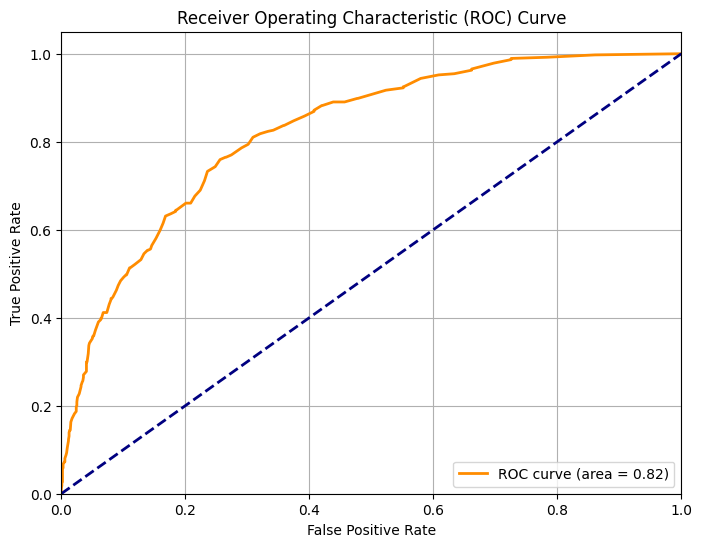

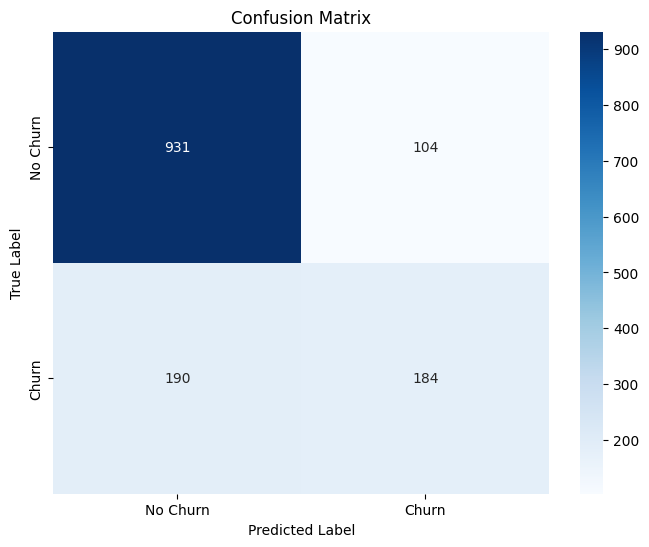

In [4]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. ROC AUC Score ---
y_proba = model.predict_proba(X_test)[:, 1] # Probabilidad de la clase positiva (Churn=1)
roc_auc = roc_auc_score(y_test, y_proba)
print(f"\nROC AUC Score: {roc_auc:.4f}")

# --- 2. Curva ROC ---
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# --- 3. Matriz de Confusión ---
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### **Interpretación del Modelo: Importancia de Variables**


Top 10 Variables Más Importantes:
                           Feature  Importance
3                     TotalCharges    0.176560
1                           tenure    0.165450
2                   MonthlyCharges    0.153867
25               Contract_Two year    0.059710
10     InternetService_Fiber optic    0.040670
28  PaymentMethod_Electronic check    0.036171
13              OnlineSecurity_Yes    0.031538
24               Contract_One year    0.029769
4                      gender_Male    0.025485
26            PaperlessBilling_Yes    0.023924


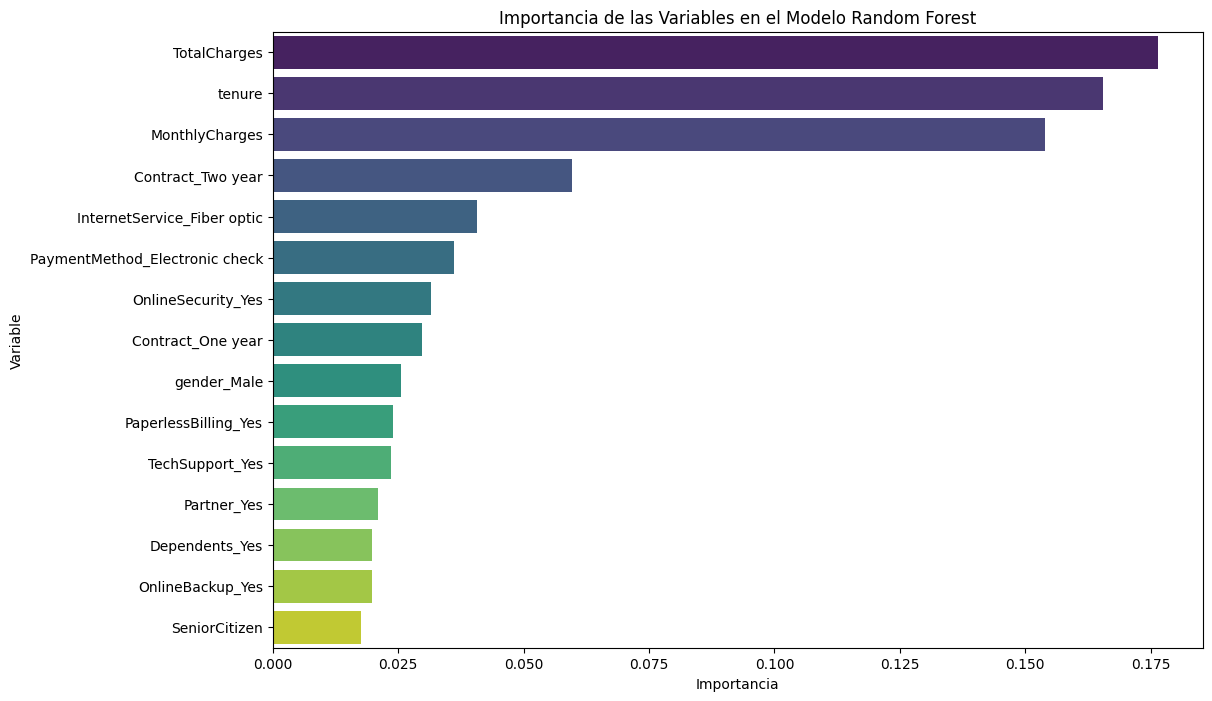

In [5]:
# --- 4. Importancia de Variables ---
feature_importances = model.feature_importances_
features = X.columns

# Crear un DataFrame para una fácil visualización y ordenamiento
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("\nTop 10 Variables Más Importantes:")
print(importance_df.head(10))

# Visualizar la importancia de las variables
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(15), palette='viridis')
plt.title('Importancia de las Variables en el Modelo Random Forest')
plt.xlabel('Importancia')
plt.ylabel('Variable')
plt.show()